In [143]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.integrate as integrate
import scipy.special as scpsp
from scipy.signal import find_peaks

In [1]:
# Environment parameters
M_sat      = 20 #mass of the perturbing satellite
m_field    = 1 #mass of the field particle
log_lambda = 10 #Coulomb Logarithm


# other constants
v        = 178
G        = 0.004491 # pc^3/Msol/Ma^2
rho_crit = 1.478e-7 # Msol/pc^3
c          = 10 #concentration parameter
softening = 0

#Globular Cluster constants:
M_0_Glob = 1e6 # total cluster mass
a_Glob = 10 # scale length

# general functions
def absolute_3(x):
    return np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)

In [125]:
#Defines the density distribution of a Plummer Profile
def Plummer_Profile(R, M_0=M_0_Glob, a=a_Glob):
    return 3 * M_0 / (4 * np.pi * a**3) * (1 + R**2 / a**2)**(-5/2)

#Gives the total mass of a Plummer Profile within Radius R
def Interior_Mass(R, M_0=M_0_Glob, a=a_Glob):
    IntegralFunction = lambda r: Plummer_Profile(r) * r**2
    M = 4 * math.pi * integrate.romberg(IntegralFunction, 0, R, divmax = 10)
    return M

#Gives radial acceleration due to a mass M
def Grav_Acceleration(M, R):
    return -M * G * R / (absolute_3(R) + softening)**3

In [126]:
# Plummer velocity dispersion

def sigma_plummer(R, M_0=M_0_Glob, a=a_Glob):
    return G * M_0 / (6 * np.sqrt(R**2 + a**2))

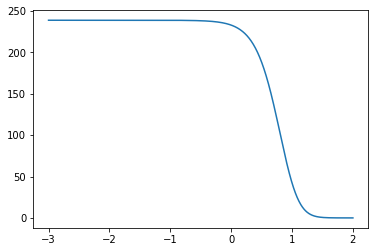

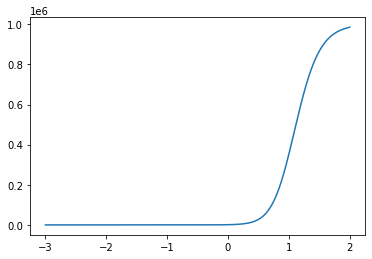

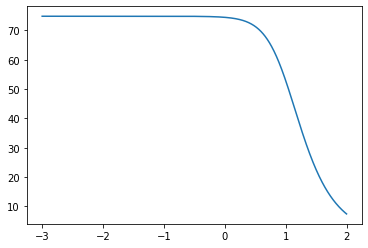

In [138]:
test_r = np.logspace(-3, 2, 1000)
test_rho = Plummer_Profile(test_r)
test_sigma = sigma_plummer(test_r)

test_m = np.zeros(1000)
for i in range(1000):
    test_m[i] = Interior_Mass(test_r[i])

plt.figure()
plt.plot(np.log10(test_r), test_rho)

plt.figure()
plt.plot(np.log10(test_r), test_m)

plt.figure()
plt.plot(np.log10(test_r), test_sigma)

In [111]:
print(sigma_plummer(10))

52.92694257181308


In [128]:
# Dynamical Friction in a Maxwellian

def term_prefix(log, rho, M=M_sat):
    #print(- 4 * np.pi * log * G**2 * rho * M)
    return - 4 * np.pi * log * G**2 * rho * M

def term_brackets(v_M, sigma):
    return (scpsp.erf(absolute_3(v_M) / (np.sqrt(2) * sigma)) -
            2 * absolute_3(v_M) / (np.sqrt(2) * sigma) / np.sqrt(np.pi) * 
            np.exp(-(absolute_3(v_M) / (np.sqrt(2) * sigma))**2))

def dynamical_friction(R, V):
    rho = Plummer_Profile(R)
    sig = sigma_plummer(R)
    return term_prefix(log_lambda, rho) / absolute_3(V)**3 * term_brackets(V, sig) * V

def simplified_dynamical_friction(R, V):
    rho = NFW_Profile(R)
    sig = 130
    return term_prefix(log_lambda, rho) / absolute_3(V)**3 * term_brackets(V, sig) * V

In [129]:
# Energy computations
def kinetic_energy(m, v):
    return .5 * m * v**2

def specific_kinetic_energy(v):
    return .5 * v**2

def potential_NFW(M, R):
    integralFunction = lambda r: r * NFW_Profile(r)
    return - G * M / R + 4 * np.pi * G * integrate.romberg(integralFunction, R, 1e5, divmax=10)

In [134]:
# leapfrog algorithm (kick-drift-kick)

# txt templates:
pos_template = 'Positions/i{i}positions.txt'
vel_template = 'Velocities/i{i}velocities.txt'
acc_template = 'Accelerations/i{i}accelerations.txt'

# setup:
n = 50000
t = .1

position = np.array([0, 10, 0])
np.savetxt(pos_template.format(i=0), position)
velocity = np.array([12, 0, 0])
np.savetxt(vel_template.format(i=0), velocity)
mass = Interior_Mass(absolute_3(position))

# 0-step acceleration:
acceleration = Grav_Acceleration(mass, position) + dynamical_friction(absolute_3(position), velocity)
np.savetxt(acc_template.format(i=0), acceleration)

# loop for every timestep:
for i in range(1, n):
    # update the position:
    position = position + t * velocity + .5 * t**2 * acceleration
    np.savetxt(pos_template.format(i=i), position)
    
    # remember the previous acceleration:
    acc_prior = acceleration
    
    #calculate the interior mass:
    mass = Interior_Mass(absolute_3(position))
    
    # extrapolate the previous velocity
    vel_intermediate = velocity + acceleration * t
    
    # calculate the next acceleration:
    acceleration = (Grav_Acceleration(mass, position) +
                    dynamical_friction(absolute_3(position), vel_intermediate))
    np.savetxt(acc_template.format(i=i), acceleration)
    
    # calculate the next velocity:
    velocity = velocity + .5 * t * (acc_prior + acceleration)
    np.savetxt(vel_template.format(i=i), velocity)

In [135]:
# read the results:
position_results = np.zeros((3, n))
velocity_results = np.zeros((3, n))
acceleration_results = np.zeros((3, n))
for i in range(n):
    position_results[:, i] = np.loadtxt('Positions/i{i}positions.txt'.format(i=i))
    velocity_results[:, i] = np.loadtxt('Velocities/i{i}velocities.txt'.format(i=i))
    acceleration_results[:, i] = np.loadtxt('Accelerations/i{i}accelerations.txt'.format(i=i))

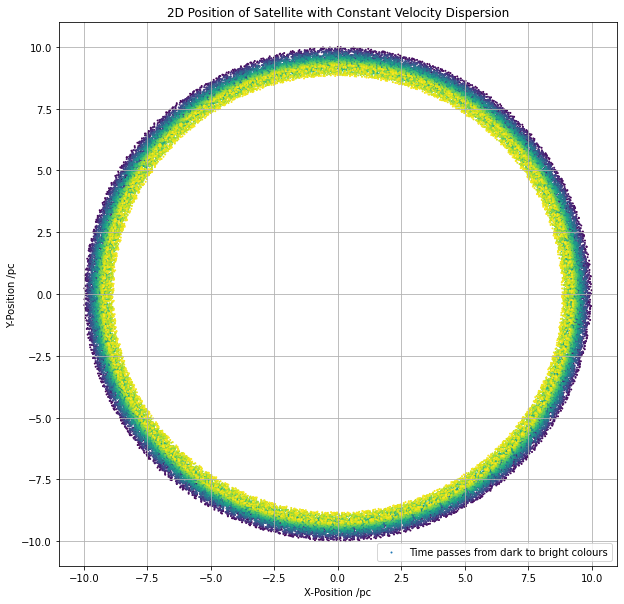

In [136]:
# plot the results:
t_range = np.linspace(0, n-1, n)
plt.figure(figsize=(10,10))
plt.scatter(position_results[0, :], position_results[1, :], 1, t_range, label='Time passes from dark to bright colours')
plt.title('2D Position of Satellite with Constant Velocity Dispersion')
plt.xlabel('X-Position /pc')
plt.ylabel('Y-Position /pc')
#plt.xlim(-15, 15)
#plt.ylim(-15, 15)
plt.legend(loc='lower right')
plt.grid()
plt.savefig('ConstantDispersion.png')

[   31    62    93 ... 49938 49967 49996]


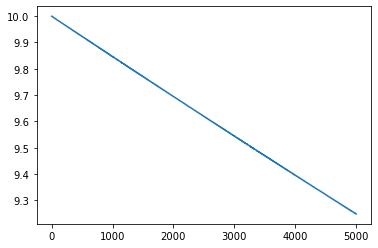

In [155]:
radiuses = np.zeros(n)
for i in range(n):
    radiuses[i] = absolute_3(position_results[:, i])

t_max, _ = find_peaks(radiuses)
print(t_max)
peaks = np.zeros(len(t_max))
for i in range(len(t_max)):
    peaks[i] = radiuses[t_max[i]]
    
plt.plot(t_max / 10, peaks)